In [1]:
import os
import re
import json
import time
import datetime
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
%matplotlib inline

In [2]:
stop = stopwords.words('english') + list(string.punctuation)

In [3]:
def get_seconds(time_str):
    m, s = time_str.split(':')
    return int(m) * 60 + int(s)

def get_minutes(seconds):
    return seconds/60

def get_time_string(time_float):
    return datetime.datetime.utcfromtimestamp(time_float).strftime('%M:%S')

In [4]:
class Log:
    def __init__(self, logfile):
        self.game_id = logfile['game_id']
        self.domain_id = logfile['domain_id']
        self.agent_ids = list(logfile['disconnected'].keys())
        self.agent_labels = logfile['agent_labels']
        self.feedback = logfile['feedback']
        self.rounds = self.load_rounds(logfile['rounds'])
        self.score = self.calculate_score()
        self.duration = self.calculate_duration()
        self.domains = self.get_domains()
        self.calculate_timestamps()

    def load_rounds(self, game_rounds):
        rounds = []
        for round_data in game_rounds:
            game_round = GameRound(round_data)
            rounds.append(game_round)
        return rounds

    def calculate_score(self):
        score = 0
        for game_round in self.rounds:
            score += game_round.score
        return score
    
    def get_domains(self):
        path = self.rounds[0].images["A"][0][0].split("/")[0]
        return [domain for domain in path.split("_")]

    def calculate_timestamps(self):
        start_time = self.rounds[0].messages[0].timestamp
        for game_round in self.rounds:
            for mesage in game_round.messages:
                mesage.timestamp = datetime.datetime.utcfromtimestamp(mesage.timestamp - start_time)

    def calculate_duration(self):
        start_time = self.rounds[0].messages[0].timestamp
        end_time = self.rounds[-1].messages[-1].timestamp
        return get_time_string(end_time - start_time)


class GameRound:
    def __init__(self, logfile_entry):
        self.round_nr = logfile_entry['round_nr']+1
        self.images = logfile_entry['images']
        self.score = self.calculate_score(logfile_entry['score'])
        self.messages = self.load_messages(logfile_entry['messages'])
        self.num_messages = self.count_text_messages()
        self.duration = self.calculate_duration()

    def load_messages(self, message_list):
        messages = []
        message_id = 0
        for message_data in message_list:
            message = Message(message_data, message_id)
            messages.append(message)
            message_id += 1
        return messages

    def calculate_score(self, score_dict):
        score = 0
        for player_score in score_dict.values():
            score += player_score
        return score
    
    def count_text_messages(self):
        count = 0
        for message in self.messages:
            if message.type == "text":
                count += 1
        return count

    def calculate_duration(self):
        start_time = self.messages[0].timestamp
        end_time = self.messages[-1].timestamp
        return get_time_string(end_time - start_time)

class Message:
    def __init__(self, logfile_message, message_id):
        self.message_id = message_id
        self.agent_id = logfile_message['agent_id']
        self.agent_label = logfile_message['agent_label']
        self.text = logfile_message['message']
        self.speaker = logfile_message['speaker']
        self.timestamp = logfile_message['timestamp']
        self.turn = logfile_message['turn']
        self.type = self.determine_message_type()
        
    def determine_message_type(self):
        if not self.text.startswith("<"):
            return "text"
        else:
            return re.findall(r'<(.*?)>', self.text)[0]

In [5]:
def load_logs(filepath="logs/"):
    print("Loading logs from {}".format(filepath))
    logs = []
    for root, dirs, files in os.walk(filepath):
        for file in files:
            if file.endswith(".json"):
                # print("Loading {}".format(os.path.join(root, file)))
                with open(os.path.join(root, file), 'r') as logfile:
                    log = Log(json.load(logfile))
                    logs.append(log)

    print("Complete. Loaded {} logs.".format(len(logs)))
    return logs


def get_messages(log, split=False):
    message_list = []
    if len(log.rounds) != 5:
        print("Conversation was not completed.")
        return []
    for game_round in log.rounds:
        round_messages = []
        for message in game_round.messages:
            text = message.text
            if not text.startswith("<"):
                round_messages.append((message.timestamp, message.speaker, text))

        if split:
            message_list.append(round_messages)
        else:
            message_list.extend(round_messages)
    return message_list


def print_conversation(log, split=False):
    message_list = get_messages(log, split)
    
    print(log.game_id)
    print("Player A: {}".format(log.agent_ids[0]))
    print("Player B: {}".format(log.agent_ids[1]))
    
    
    if split:
        for i, round_messages in enumerate(message_list):
            print("- - Round {} - -".format(i+1))
            print_messages(round_messages)
    else:
        print_messages(message_list)
        
#     print(log.feedback)


def print_messages(message_list):
    for message in message_list:
        timestamp = message[0].strftime('%M:%S')
        print("[{}] {}: {}".format(timestamp, message[1], message[2]))


def print_game_statistics(log):
    print("\n- - Game statistics - -")
    print("Duration: {} min. Score: {}/30 points.".format(log.duration, log.score))
    for i, game_round in enumerate(log.rounds):
        print("[Round {}] Duration: {} min. Score: {}/6 points. Number of messages: {}.".format(i, game_round.duration, game_round.score, game_round.num_messages))

In [6]:
def collect_dataset(logs):
    labels = ["Game_ID", "Game_Domain_ID", "Game_Domain_1", "Game_Domain_2", "Game_Duration", "Game_Score", "Game_Feedback_A", "Game_Feedback_B", \
              "Round_Nr", "Round_Duration", "Round_Scores", "Round_Images_A", "Round_Images_B", \
              "Message_Nr", "Message_Timestamp", "Message_Turn", "Message_Agent_ID", "Message_Agent_Label", \
              "Message_Speaker", "Message_Type", "Message_Text"]
    dataset = []
    for log in logs:
        game_data = [log.game_id, log.domain_id, log.domains[0], log.domains[1], get_seconds(log.duration), log.score, log.feedback["A"], log.feedback["B"]]
        for game_round in log.rounds:
            round_data = [game_round.round_nr, get_seconds(game_round.duration), game_round.score, game_round.images["A"], game_round.images["B"]]
            for message in game_round.messages:
                message_data = [message.message_id, message.timestamp, message.turn, message.agent_id, message.agent_label, \
                                message.speaker, message.type, message.text] 
                dataset.append(game_data + round_data + message_data)
                
    df = pd.DataFrame(dataset, columns=labels)
                
    return df 

In [7]:
logs = load_logs()
nr_logs = len(logs)
for i, log in enumerate(logs):
    print("\n- - Game {} - -".format(i+1))
    print_conversation(log, split=True)
    
    print_game_statistics(log)

Loading logs from logs/
Complete. Loaded 9 logs.

- - Game 1 - -
333U7HK6IADTMJB5OO2Z5F8W2VXJDB39N5ACM9HFLD541M7L2HGFBIKAD9PB
Player A: A6MWJK1YEY5L2
Player B: AMDX0UNZS4A1G
- - Round 1 - -
[00:00] A: Do you have a picture of a large truck behind a dark blue car?
[00:09] B: yes
[00:17] A: You go next
[00:37] B: do you have a picture of a blue pickup truck sitting on grass?
[00:49] A: no
[01:02] B: Ok you go ahead
[01:18] A: do you have a picture of a blue truck with lots of colorful luggage on it?
[01:59] B: Yes I do! That was what I was going to ask about next.
[02:07] A: I do too.
[02:17] B: Did you need any others?
[02:23] A: yeah, one more.
[02:30] B: Go ahead
[02:49] A: Do you have a picture with a truck with text saying 'schepps' on the back of it.
[03:08] B: No i don't
[03:12] A: okay.
- - Round 2 - -
[03:49] A: You go first.
[04:22] B: Ok, Do you have a picture of a red van with the side door open
[04:31] A: No
[04:39] B: ok
[04:53] A: Do you have a picture of the blue truck wi

In [8]:
dataset = collect_dataset(logs)
dataset.columns

Index(['Game_ID', 'Game_Domain_ID', 'Game_Domain_1', 'Game_Domain_2',
       'Game_Duration', 'Game_Score', 'Game_Feedback_A', 'Game_Feedback_B',
       'Round_Nr', 'Round_Duration', 'Round_Scores', 'Round_Images_A',
       'Round_Images_B', 'Message_Nr', 'Message_Timestamp', 'Message_Turn',
       'Message_Agent_ID', 'Message_Agent_Label', 'Message_Speaker',
       'Message_Type', 'Message_Text'],
      dtype='object')

In [9]:
dataset.to_csv('conversations.csv', index = False)

In [10]:
dataset.to_pickle('conversations.pickle')

In [11]:
game_times = dataset.groupby('Game_ID').mean()['Game_Duration']
game_times_list = [get_minutes(duration) for duration in list(game_times)]
print(game_times_list)

[19.633333333333333, 7.8666666666666663, 9.5500000000000007, 14.216666666666667, 8.4666666666666668, 15.449999999999999, 10.050000000000001, 18.75, 12.616666666666667]


In [12]:
print(np.mean(game_times_list))

12.9555555556


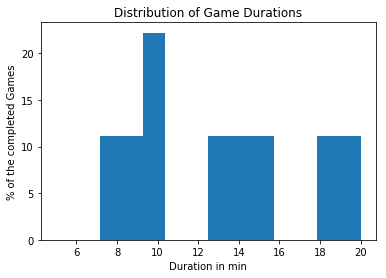

In [13]:
plt.hist(game_times_list, bins=np.linspace(5,20,15), weights=np.zeros_like(game_times_list) + 100. / len(game_times_list))  # arguments are passed to np.histogram
plt.title("Distribution of Game Durations")
plt.xlabel("Duration in min")
plt.ylabel("% of the completed Games")
plt.draw()
ax = plt.gca()
xticks = [str(label.get_text())+" min" for label in ax.get_xticklabels()][1:-1]
ax.set_xticklabels = xticks
plt.draw()
plt.show()

In [14]:
games_df = dataset.groupby('Game_ID')

In [15]:
game_statistics = defaultdict(lambda: (defaultdict(lambda: [])))

for game_df in games_df:
#     print("Game {}".format(game_df[0]))
    rounds_df = game_df[1].groupby('Round_Nr')
    for round_df in rounds_df:
#         print("Round {}".format(round_df[0]))
        player_data_df = round_df[1].groupby('Message_Agent_ID')
        token_sum = 0
        message_sum = 0
        for player_df in player_data_df:
            
            messages = player_df[1].loc[player_df[1]['Message_Type'] == 'text']
            message_list = messages['Message_Text'].tolist()
            no_tokens = 0
            for m in message_list:
                tokens = [i for i in word_tokenize(m.lower()) if i not in stop]
#                 print(tokens)
#                 print(len(tokens))
                no_tokens += len(tokens)
            token_sum += no_tokens
            message_sum += len(message_list)
#             print("Agent {} used {} tokens in {} messages.".format(player_df[0], no_tokens, len(message_list)))
            
        game_statistics["tokens"][round_df[0]].append(token_sum)
        game_statistics["messages"][round_df[0]].append(message_sum)
        game_statistics["duration"][round_df[0]].append(round_df[1].mean()["Round_Duration"])
#         print("Total tokens: {}. Total messages: {}. Duration: {}".format(token_sum, message_sum, get_time_string(round_df[1].mean()["Round_Duration"])))
#     print("\n-------\n")
   

In [16]:
def plot_game_data(mu, sigma, t, title, x_label, y_label, filename=None):
    fig, ax = plt.subplots(1, figsize=(10,6))
    ax.plot(t, mu, lw=2, label='mean population 1', color='blue')
    ax.fill_between(t, mu+sigma, mu-sigma, facecolor='blue', alpha=0.3)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xticks(t)
    ax.grid()
    fig.show()
    if filename:
        fig.savefig(filename, bbox_inches='tight')

Round 1: Token counts [43, 30, 26, 86, 34, 106, 34, 75, 51]
Round 2: Token counts [47, 37, 31, 48, 34, 40, 35, 127, 43]
Round 3: Token counts [39, 21, 27, 48, 32, 45, 32, 53, 26]
Round 4: Token counts [42, 31, 20, 38, 31, 23, 29, 34, 39]
Round 5: Token counts [71, 16, 18, 38, 52, 18, 22, 27, 38]


/home/janosch/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


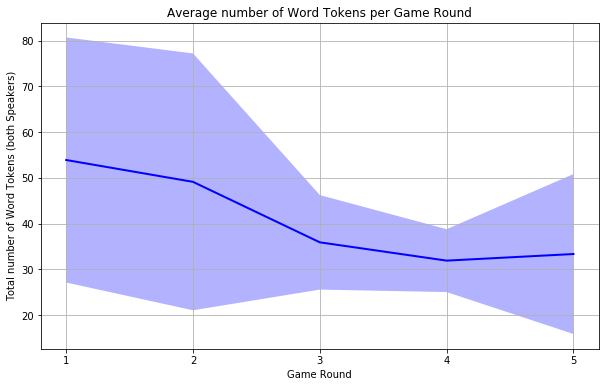

In [17]:
data_array = np.empty([5, nr_logs])

for round_nr, token_counts in game_statistics["tokens"].items():    
    print("Round {}: Token counts {}".format(round_nr, token_counts))
    data_array[round_nr-1] = token_counts
    
mu = data_array.mean(axis=1)
sigma = data_array.std(axis=1)
t = np.arange(1, 6, 1)

title = 'Average number of Word Tokens per Game Round'
x_label = 'Game Round'
y_label = 'Total number of Word Tokens (both Speakers)'
filename = 'tokens.pdf'


plot_game_data(mu, sigma, t, title, x_label, y_label, filename)

Round 1: Message counts [15, 8, 9, 19, 12, 22, 11, 18, 12]
Round 2: Message counts [17, 12, 8, 17, 10, 13, 13, 28, 12]
Round 3: Message counts [14, 9, 8, 18, 12, 14, 12, 20, 10]
Round 4: Message counts [16, 14, 8, 17, 12, 12, 15, 14, 13]
Round 5: Message counts [25, 8, 12, 16, 15, 10, 12, 13, 12]


/home/janosch/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


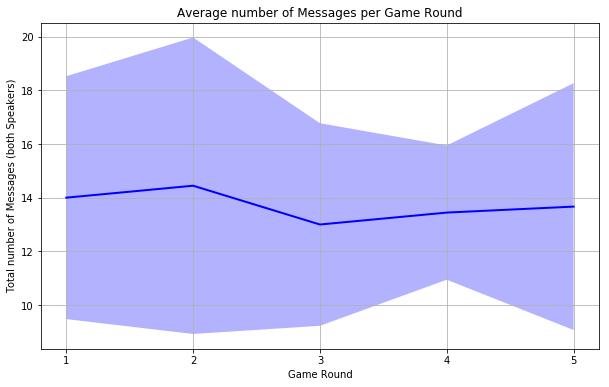

In [18]:
data_array = np.empty([5, nr_logs])

for round_nr, token_counts in game_statistics["messages"].items():    
    print("Round {}: Message counts {}".format(round_nr, token_counts))
    data_array[round_nr-1] = token_counts
    
mu = data_array.mean(axis=1)
sigma = data_array.std(axis=1)
t = np.arange(1, 6, 1)

title = 'Average number of Messages per Game Round'
x_label = 'Game Round'
y_label = 'Total number of Messages (both Speakers)'
filename = 'messages.pdf'


plot_game_data(mu, sigma, t, title, x_label, y_label, filename)

Round 1: Duration [219.0, 79.0, 87.0, 283.0, 77.0, 361.0, 140.0, 299.0, 192.0]
Round 2: Duration [219.0, 122.0, 162.0, 162.0, 89.0, 157.0, 121.0, 441.0, 167.0]
Round 3: Duration [193.0, 57.0, 89.0, 127.0, 92.0, 164.0, 69.0, 145.0, 101.0]
Round 4: Duration [178.0, 90.0, 76.0, 125.0, 78.0, 89.0, 106.0, 100.0, 93.0]
Round 5: Duration [333.0, 97.0, 81.0, 104.0, 129.0, 105.0, 102.0, 99.0, 142.0]


/home/janosch/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


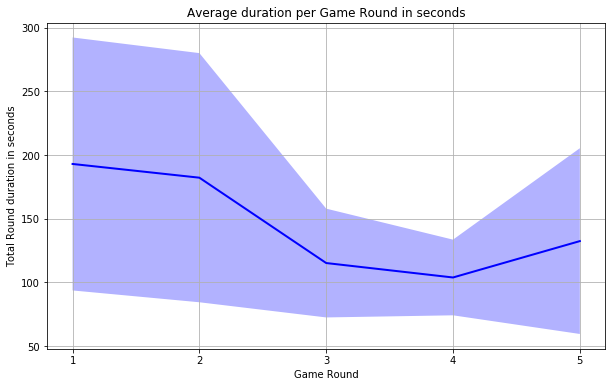

In [19]:
data_array = np.empty([5, nr_logs])

for round_nr, token_counts in game_statistics["duration"].items():    
    print("Round {}: Duration {}".format(round_nr, token_counts))
    data_array[round_nr-1] = token_counts
    
mu = data_array.mean(axis=1)
sigma = data_array.std(axis=1)
t = np.arange(1, 6, 1)

title = 'Average duration per Game Round in seconds'
x_label = 'Game Round'
y_label = 'Total Round duration in seconds'
filename = 'duration.pdf'


plot_game_data(mu, sigma, t, title, x_label, y_label, filename)

In [20]:
for game_id, game_df in games_df:
    selections = game_df.loc[game_df['Message_Type'] == 'selection']['Message_Text']
    sel_images = [elements.split()[2] for elements in selections]
    print(len(set(sel_images)))

8
8
7
7
8
8
8
8
7
